<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Social Media Data Analysis - Final Project</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Analysis</h2>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">Julia King</h4>
</div>
<br>

In [1]:
# import block

# own functions
from common_functions import confirm_execution, read_gtrends_df, read_comment_df, read_video_df

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# h1
from scipy.stats import chi2_contingency

# h3 
from scipy.stats import mannwhitneyu


In [2]:
# overarching functions

def row_share(df : pd.DataFrame) -> pd.DataFrame:
    """Given a df with numeric values, converts all entries to the share of the row: cell = cell/sum(row)

    Args:
        df (pd.DataFrame): df with numeric columns only

    Returns:
        pd.DataFrame: df with the cells converted
    """
    return df.div(df.sum(axis = 1), axis = 0)

# overarching variables
phase_labels = ["before", "1st spike", "2nd spike", "after"]

# 7. Conduct statistical analysis to test the hypotheses above.

## 7.1 Videos produced before the first spike in public interest are more likely to be non-conspirative compared to those uploaded during and after the spike.

H0: Videos produced before the first spike in public interest are less or equally likely to be non-conspirative compared to those uploaded during and after the spike.

To test the hypothesis, i will need to test for statistical independence of two categorical variables: conspirative and phase. Thus, a Chi-Square test will be applied.

In [3]:
# load relevant data

video_df = read_video_df()

In [4]:
# create contingency table

h1_contingency = pd.crosstab(video_df["phase"],video_df["conspirative_auto"], margins = False)

h1_contingency

conspirative_auto,False,True
phase,,
0,182,88
1,311,880
2,184,370
3,440,488


In [5]:
# calculate version of df with proportions instead of absolute numbers

h1_shares = row_share(h1_contingency)

h1_shares

conspirative_auto,False,True
phase,,
0,0.674074,0.325926
1,0.261125,0.738875
2,0.332130,0.667870
3,0.474138,0.525862


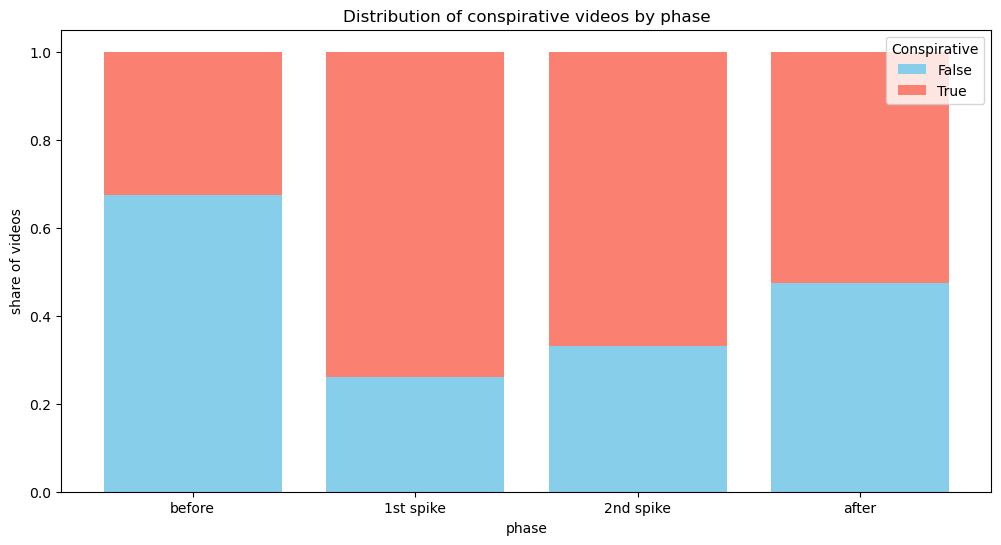

In [6]:
# plot share of conspirative videos per phase
plt.figure(figsize = (12, 6))
plt.bar(phase_labels, h1_shares[False], label = "False", color = "skyblue")
plt.bar(phase_labels, h1_shares[True], bottom = h1_shares[False], label = "True", color = "salmon")

# Labels + title
plt.xlabel("phase")
plt.ylabel("share of videos")
plt.title("Distribution of conspirative videos by phase")
plt.legend(title = "Conspirative")

# Show plot
plt.show()

In [7]:
h1_chi2, h1_p, h1_dof, h1_expected = chi2_contingency(h1_contingency)
h1_expected = pd.DataFrame(h1_expected, index = h1_contingency.index, columns = h1_contingency.columns)

print("Chi-square statistic:", h1_chi2)
print("p-value:", h1_p)
print("Expected distributions under h0: \n", h1_expected)

Chi-square statistic: 210.93240934076437
p-value: 1.8309036247353845e-45
Expected distributions under h0: 
 conspirative_auto       False       True 
phase                                    
0                  102.477064  167.522936
1                  452.037717  738.962283
2                  210.267754  343.732246
3                  352.217465  575.782535


We can already observe that it is extremely unlikely that all 4 phases belong to the same distribution. 

In [8]:
# print percent deviations from expected when assuming independence

h1_shares - row_share(h1_expected)

conspirative_auto,False,True
phase,,
0,0.294529,-0.294529
1,-0.118420,0.118420
2,-0.047415,0.047415
3,0.094593,-0.094593


Once again, clear deviations between the phases are obvious. Most importantly, phase 0 (before the first spike) has significantly less conspirative videos than the other phases, further strengthening the hypothesis.

In [9]:
# finally, re-compute chi square with phase 1, 2, 3 grouped
h1_group_cont = pd.DataFrame({colname : [h1_contingency.iloc[0][colname], h1_contingency.iloc[1:][colname].sum()] for colname in h1_contingency.columns})
h1_group_cont

,False,True
0,182,88
1,935,1738


In [10]:
h1_group_chi2, h1_group_p, h1_group_dof, h1_group_expected = chi2_contingency(h1_group_cont)
h1_group_expected = pd.DataFrame(h1_group_expected, index = h1_group_cont.index, columns = h1_group_cont.columns)

print("Chi-square statistic:", h1_group_chi2)
print("p-value:", h1_group_p)
print("Expected distributions under h0: \n", h1_group_expected)

Chi-square statistic: 108.1335440941017
p-value: 2.512648199037469e-25
Expected distributions under h0: 
          False        True 
0   102.477064   167.522936
1  1014.522936  1658.477064


We once again observe a significant difference between "before the spike" and "during / after the spikes". Additionally, the difference is in line with our hypothesis: The share of conspirative videos in phases 1-3 is higher than expected under statistical independence and lower than expected for phase 0. Based on the results of this analysis, we can confidently reject the null hypothesis.

## 7.2. Comments under conspirative videos express higher levels of negative sentiment compared to comments under non-conspirative videos.

H0: Comments under conspirative videos express lower or the same levels of negative sentiment compared to comments under non-conspirative videos.

In [11]:
# load relevant data
video_df = read_video_df()
comment_df = read_comment_df()

In [12]:
# create merged df with conspirative label and mood

h2_df = pd.merge(comment_df, video_df["conspirative_auto"], left_on = "video_id", right_index = True)

h2_df.sample(3) # using sample to show different video ids

,phase,week_start,video_id,text,label_leia,conspirative_auto
comment_id,,,,,,
UgxeLBniGXdUQmVhpFN4AaABAg,2,2023-08-20,0HQsOYCiEeA,"Calling this shit out is one thing, stopping i...",Anger,True
UgwQMTHwRMomP1Qg4Sp4AaABAg,1,2023-03-05,gwknbhpWPxs,They will just make an app to download so we c...,Anger,True
UgwC3m7Md8o4mZXBWhl4AaABAg,1,2023-06-04,w5Io4J9alOM,Think its time that a general strike was organ...,Anger,True


In [13]:
h2_contingency = pd.crosstab(h2_df["conspirative_auto"], h2_df["label_leia"], margins = False)
h2_contingency

label_leia,Affection,Anger,Fear,Happiness,Sadness
conspirative_auto,,,,,
False,6330,23998,7754,6788,3691
True,20916,91396,19048,15689,8483


In [14]:
h2_shares = row_share(h2_contingency)
h2_shares = h2_shares[["Happiness", "Affection", "Sadness", "Anger", "Fear"]]
h2_shares

label_leia,Happiness,Affection,Sadness,Anger,Fear
conspirative_auto,,,,,
False,0.139783,0.130352,0.076007,0.494183,0.159675
True,0.100873,0.134480,0.054542,0.587635,0.122470


In [15]:
# add grouped version

h2_group_shares = pd.DataFrame({
    "Positive": h2_shares[["Affection", "Happiness"]].sum(axis=1),
    "Negative": h2_shares[["Anger", "Fear", "Sadness"]].sum(axis=1)
}, index = h2_shares.index)

h2_group_shares

,Positive,Negative
conspirative_auto,,
False,0.270134,0.729866
True,0.235353,0.764647


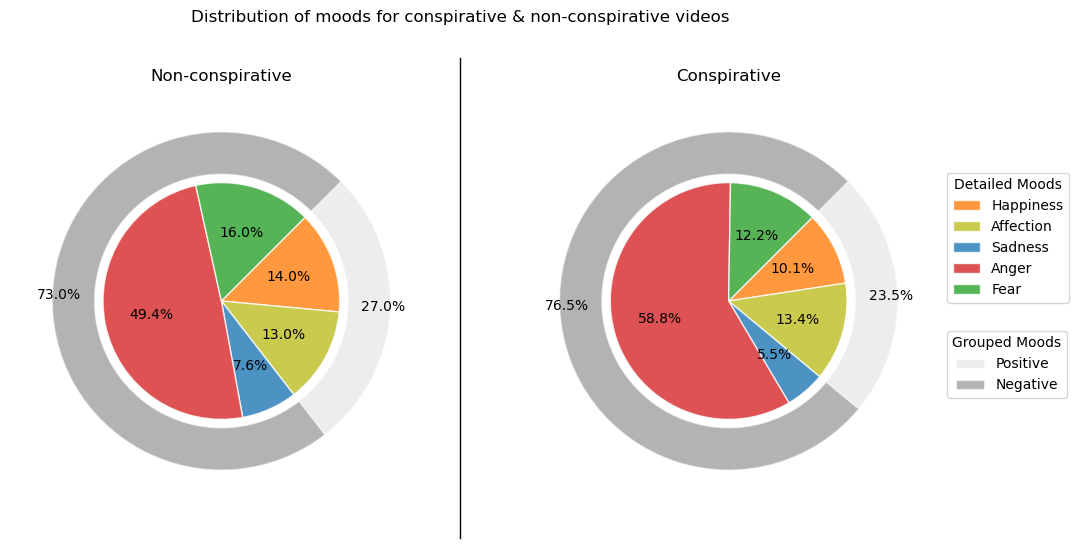

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

mood_colors = {"Affection" : "#bcbd22", 
               "Anger" : "#d62728", 
               "Fear" : "#2ca02c", 
               "Happiness" : "#ff7f0e", 
               "Sadness" : "#1f77b4", 
               "Positive" : "gainsboro", 
               "Negative" : "dimgrey"}

# Flatten the axes array for easier indexing
ax = ax.flatten()

# Plot the original sentiment shares
for i, row in enumerate(h2_shares.index):
    # Original sentiment pie
    wedges_inner, texts_inner, autotexts_inner = ax[i].pie(h2_shares.loc[row], 
                          colors = [mood_colors[label] for label in h2_shares.columns], 
                          autopct = "%1.1f%%", 
                          startangle = 45, 
                          counterclock = False,
                          radius = 0.7, 
                          wedgeprops = dict(edgecolor = "w", linewidth = 1, alpha = 0.8))
    
    # Overlay grouped sentiment pie
    wedges_outer, texts_outer, autotexts_outer = ax[i].pie(h2_group_shares.loc[row], 
              colors = [mood_colors[label] for label in h2_group_shares.columns], 
              autopct = "%1.1f%%", 
              startangle = 45, 
              counterclock = False,
              radius = 1,
              wedgeprops = dict(width = 0.25, edgecolor = "w", linewidth = 1, alpha = 0.5))
    
    # Move outer layer text further away from center
    for text in autotexts_outer:
        text.set_verticalalignment("center")
        text.set_horizontalalignment("center")
        text.set_x(text.get_position()[0] * 1.6)  
    
    # Set title
    ax[i].set_title(f"{"Conspirative" if row else "Non-conspirative"}")

# Add legends
ax[1].legend(wedges_inner, h2_shares.columns, title = "Detailed Moods", loc = "center left", bbox_to_anchor = (1, 0.15, 0.5, 1))
ax[0].legend(wedges_outer, h2_group_shares.columns, title = "Grouped Moods", loc = "center left", bbox_to_anchor = (2.2, -0.15, 0.5, 1))

# Add separation line
line = plt.Line2D((.5, .5), (.1, .9), color = "k", linewidth = 1)
fig.add_artist(line)

# Adjust layout
plt.suptitle("Distribution of moods for conspirative & non-conspirative videos")

# Show plot
plt.show()


We can observe significant differences in the distribution of detailed moods. This is especially pronounced with Anger, increasing from 49% to 59%. However, the differences in grouped moods are much less pronounced, only differing by ~3%.

We first conduct some analysis on the detailed moods.

In [17]:
# chi squared test

h2_chi2, h2_p, h2_dof, h2_expected = chi2_contingency(h2_contingency)
h2_expected = pd.DataFrame(h2_expected, index = h2_contingency.index, columns = h2_contingency.columns)

print("Chi-square statistic:", h2_chi2)
print("p-value:", h2_p)
print("Expected distributions under h0: \n", h2_expected)

Chi-square statistic: 1761.0159619007134
p-value: 0.0
Expected distributions under h0: 
 label_leia            Affection         Anger         Fear     Happiness  \
conspirative_auto                                                          
False               6482.794638  27456.346048   6377.15121   5348.079537   
True               20763.205362  87937.653952  20424.84879  17128.920463   

label_leia             Sadness  
conspirative_auto               
False              2896.628566  
True               9277.371434  


In [18]:
h2_diff_shares = h2_shares - row_share(h2_expected)

h2_diff_shares

label_leia,Affection,Anger,Fear,Happiness,Sadness
conspirative_auto,,,,,
False,-0.003146,-0.071217,0.028353,0.029652,0.016358
True,0.000982,0.022236,-0.008853,-0.009258,-0.005107


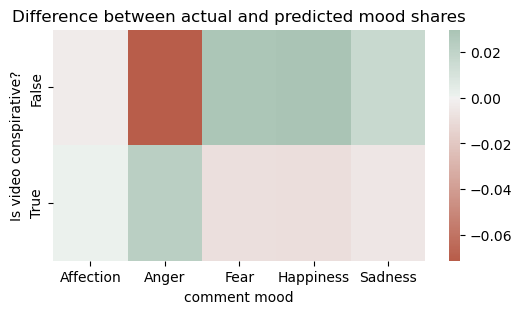

In [19]:
plt.figure(figsize = (6, 3))
sns.heatmap(h2_diff_shares, 
            cmap = sns.diverging_palette(20, 145, s = 60, as_cmap = True), 
            center = 0)
plt.title("Difference between actual and predicted mood shares")
plt.xlabel("comment mood")
plt.ylabel("Is video conspirative?")

plt.show()

The plot reveals an important insight: Conspirative videos are significantly more likely illicit anger than non-conspirative videos. 
We now conduct a test for the hypothesis regarding grouped variables.

In [20]:
h2_group_cont = pd.DataFrame({
    "Positive": h2_contingency[["Affection", "Happiness"]].sum(axis=1),
    "Negative": h2_contingency[["Anger", "Fear", "Sadness"]].sum(axis=1)
}, index = h2_contingency.index)

h2_group_cont

,Positive,Negative
conspirative_auto,,
False,13118,35443
True,36605,118927


In [21]:
# chi squared test

h2_group_chi2, h2_group_p, h2_group_dof, h2_group_expected = chi2_contingency(h2_group_cont)
h2_group_expected = pd.DataFrame(h2_group_expected, index = h2_group_cont.index, columns = h2_group_cont.columns)

print("Chi-square statistic:", h2_group_chi2)
print("p-value:", h2_group_p)
print("Expected distributions under h0: \n", h2_group_expected)

Chi-square statistic: 242.7511249393658
p-value: 9.882149642024045e-55
Expected distributions under h0: 
                        Positive       Negative
conspirative_auto                             
False              11830.874175   36730.125825
True               37892.125825  117639.874175


In [22]:
h2_group_shares - row_share(h2_group_expected)

,Positive,Negative
conspirative_auto,,
False,0.026505,-0.026505
True,-0.008276,0.008276


As seen before, the magnitude of the differences between positive and negative sentiment is much smaller than the differences in individual sentiments. Thus, while we do find significant evidence for a difference in grouped moods, the small magnitude makes it hard to draw interesting conclusions.

## 7.3. The engagement metrics (e.g., likes, comments, shares per view) of conspirative videos differ significantly from those of non-conspirative videos, with conspirative videos having higher engagement rates per view.

H0: There is no significant difference in engagement rates (likes, comments, shares per view) between conspirative and non-conspirative videos.

In [23]:
# load relevant data
video_df = read_video_df()

In [24]:
# filter for videos with views and create relevant variables
# filtering is done cause videos with 0 views will not have engagements

engagement_df = video_df[video_df["views"] > 0].copy()
engagement_df["likes_per_view"] = engagement_df["likes"] / engagement_df["views"]
engagement_df["comments_per_view"] = engagement_df["comments"] / engagement_df["views"]

# the youtube api returned some obviously false numbers (a few items with more likes than views). This persists even after reruns. Thus, they are discarded.
engagement_df = engagement_df[(engagement_df["likes_per_view"] <= 1) & (engagement_df["comments_per_view"] <= 1)]

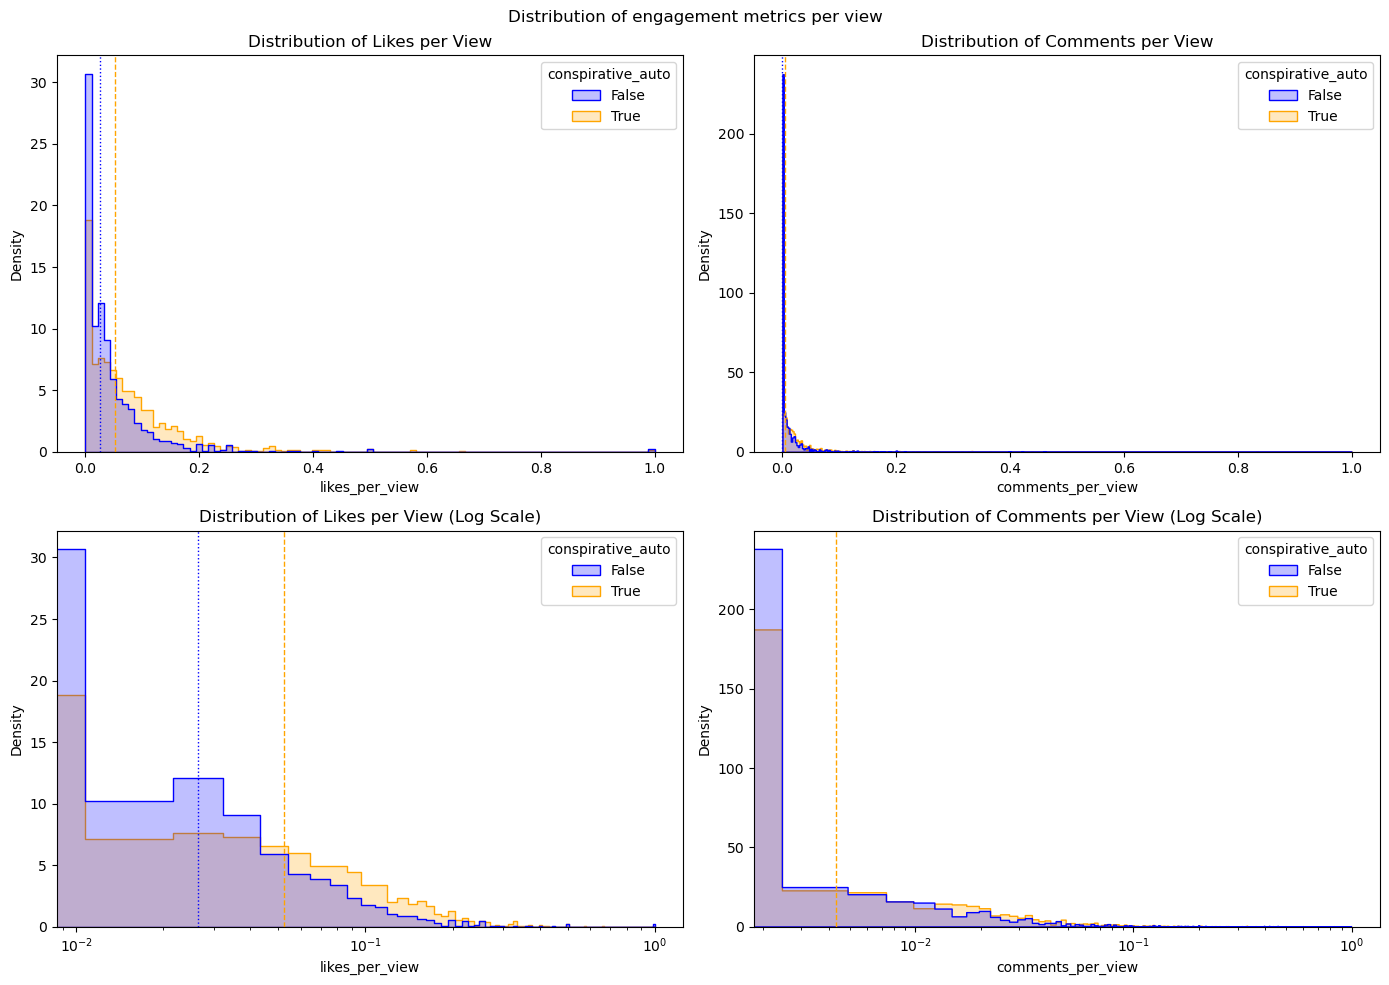

In [34]:
colors = ["blue", "orange"] # first element is False, second is True

# plot distributions
fig, ax = plt.subplots(2, 2, figsize = (14, 10))

# likes 
sns.histplot(data = engagement_df, x = "likes_per_view", hue = "conspirative_auto", element = "step", stat = "density", 
             common_norm = False, ax = ax[0, 0], palette = colors)
ax[0, 0].set_title("Distribution of Likes per View")
ax[0, 0].axvline(engagement_df[engagement_df["conspirative_auto"] == True]["likes_per_view"].median(), color = colors[1], linestyle = "--", linewidth = 1)
ax[0, 0].axvline(engagement_df[engagement_df["conspirative_auto"] == False]["likes_per_view"].median(), color = colors[0], linestyle = ":", linewidth = 1)

# comments
sns.histplot(data = engagement_df, x = "comments_per_view", hue = "conspirative_auto", element = "step", stat = "density", 
             common_norm = False, ax = ax[0, 1], palette = colors)
ax[0, 1].axvline(engagement_df[engagement_df["conspirative_auto"] == True]["comments_per_view"].median(), color = colors[1], linestyle = "--", linewidth = 1)
ax[0, 1].axvline(engagement_df[engagement_df["conspirative_auto"] == False]["comments_per_view"].median(), color = colors[0], linestyle = ":", linewidth = 1)
ax[0, 1].set_title("Distribution of Comments per View")

# same with log
sns.histplot(data = engagement_df, x = "likes_per_view", hue = "conspirative_auto", element = "step", stat = "density", 
             common_norm = False, ax = ax[1, 0], palette = colors)
ax[1, 0].set_title("Distribution of Likes per View (Log Scale)")
ax[1, 0].set_xscale("log")
ax[1, 0].axvline(engagement_df[engagement_df["conspirative_auto"] == True]["likes_per_view"].median(), color = colors[1], linestyle = "--", linewidth = 1)
ax[1, 0].axvline(engagement_df[engagement_df["conspirative_auto"] == False]["likes_per_view"].median(), color = colors[0], linestyle = ":", linewidth = 1)

sns.histplot(data = engagement_df, x = "comments_per_view", hue = "conspirative_auto", element = "step", stat = "density", 
             common_norm = False, ax = ax[1, 1], palette = colors)
ax[1, 1].set_title("Distribution of Comments per View (Log Scale)")
ax[1, 1].set_xscale("log")
ax[1, 1].axvline(engagement_df[engagement_df["conspirative_auto"] == True]["comments_per_view"].median(), color = colors[1], linestyle = "--", linewidth = 1)
ax[1, 1].axvline(engagement_df[engagement_df["conspirative_auto"] == False]["comments_per_view"].median(), color = colors[0], linestyle = ":", linewidth = 1)

# Adjust layout
fig.suptitle("Distribution of engagement metrics per view")
plt.tight_layout()
plt.show()


As expected, the distributions are very non-normal, even when logged. Thus, a non-parametric model is chosen instead of a t-test. This test compares the medians of the two distributions, which is adequate here, as we have such very non-normal distributions.

In the logged plots, we can observe the expected trend: The median comment and like counts of conspirative videos are higher than those of non-conspirative ones, with the median non-conspirative video even receiving 0 comments! 

We will test if these differences are significant.

In [26]:
# testing likes
likes_conspirative = engagement_df[engagement_df["conspirative_auto"] == 1]["likes_per_view"]
likes_non_conspirative = engagement_df[engagement_df["conspirative_auto"] == 0]["likes_per_view"]
u_stat_likes, p_value_likes = mannwhitneyu(likes_conspirative, likes_non_conspirative)

# testing comments
comments_conspirative = engagement_df[engagement_df["conspirative_auto"] == 1]["comments_per_view"]
comments_non_conspirative = engagement_df[engagement_df["conspirative_auto"] == 0]["comments_per_view"]
u_stat_comments, p_value_comments = mannwhitneyu(comments_conspirative, comments_non_conspirative)

print(f"Mann-Whitney U Test for Likes per View: U-statistic = {u_stat_likes}, p-value = {p_value_likes}")
print(f"Mann-Whitney U Test for Comments per View: U-statistic = {u_stat_comments}, p-value = {p_value_comments}")

Mann-Whitney U Test for Likes per View: U-statistic = 1169852.5, p-value = 1.4971191681948755e-33
Mann-Whitney U Test for Comments per View: U-statistic = 1064695.5, p-value = 2.5576648406498495e-13


The differences appear significant.

## 7.4 Conspiracy Narratives over Time

In [27]:
# load relevant data
gtrends_df = read_gtrends_df()
video_df = read_video_df()
comment_df = read_comment_df()

In [28]:
video_time_df = video_df.groupby("week_start")[["views", "likes", "comments", "conspirative_auto"]].mean()

# normalize data a bit, so i can visualize trends instead of individual outliers
video_time_df[["views", "likes", "comments", "conspirative_auto"]] = video_time_df[["views", "likes", "comments", "conspirative_auto"]].rolling(window = 5, min_periods = 1).mean()
video_time_df.head(3)

,views,likes,comments,conspirative_auto
week_start,,,,
2022-03-20,423.666667,33.666667,21.333333,0.333333
2022-03-27,217.833333,16.833333,10.666667,0.166667
2022-04-03,346.597222,25.472222,8.986111,0.277778


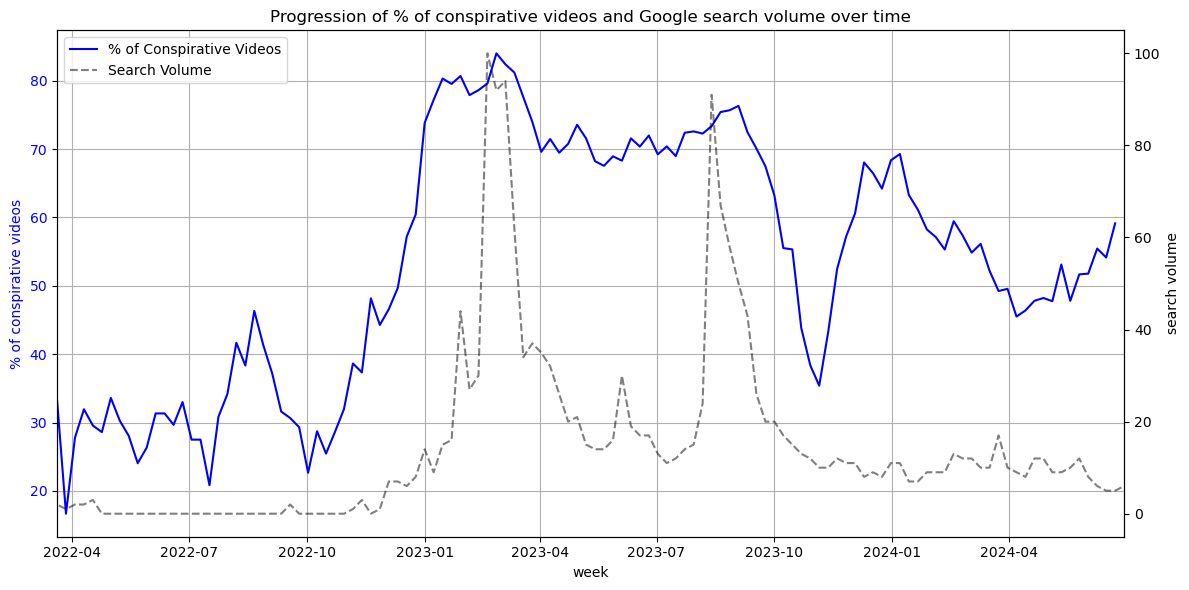

In [29]:
# add visualization of progression of share of conspirative videos

# % of conspirative videos on left axis
fig, ax1 = plt.subplots(figsize = (12, 6))


ax1.plot(pd.to_datetime(video_time_df.index), video_time_df["conspirative_auto"] * 100, label = "% of Conspirative Videos", color = "blue")
ax1.set_xlabel("week")
ax1.set_ylabel("% of conspirative videos", color = "blue")
ax1.tick_params(axis = "y", labelcolor = "blue")

# search volume on right axis
ax2 = ax1.twinx()
ax2.plot(gtrends_df["date"], gtrends_df["volume"], label = "Search Volume", color = "black", linestyle = "--", alpha = 0.5)
ax2.set_ylabel("search volume", color = "black")
ax2.tick_params(axis = "y", labelcolor = "black")

# Set the x-axis limits
ax1.set_xlim(pd.to_datetime(video_time_df.index).min(), pd.to_datetime(gtrends_df["date"]).max())

# legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc = "upper left")

# # Title + grid + layout
plt.title("Progression of % of conspirative videos and Google search volume over time")
ax1.grid(True)
plt.tight_layout()

plt.show()

As seen earlier, the percentage of conspirative videeos is highest around the peaks.

For further discussion of the results and limitations, see the report.